### Custom TowerBuilder game with Gymnasium + Stable-Baselines3

#### Imports & helpers

We import Python libraries, Box2D, and Stable-Baselines3.
We also define a draw_world helper function that renders the Box2D world into an RGB NumPy array using Matplotlib.

In [20]:
import os, math, random, numpy as np
import gymnasium as gym
from gymnasium import spaces
import imageio
import matplotlib.pyplot as plt

# Box2D
from Box2D import (b2World, b2PolygonShape, b2_staticBody, b2_dynamicBody)

# Rendering helper (matplotlib to frames)
def draw_world(world, cam, W=256, H=256):
    """
    Draw Box2D bodies into an RGB array using matplotlib.
    cam = dict(xmin, xmax, ymin, ymax) world-coordinates to show.
    """
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(W/100, H/100), dpi=100)
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlim(cam['xmin'], cam['xmax'])
    ax.set_ylim(cam['ymin'], cam['ymax'])
    ax.axis('off')

    for body in world.bodies:
        for fixture in body.fixtures:
            shape = fixture.shape
            if isinstance(shape, b2PolygonShape):
                verts = [body.transform * v for v in shape.vertices]
                xs = [v[0] for v in verts]
                ys = [v[1] for v in verts]
                ax.fill(xs, ys, alpha=0.9)

    fig.canvas.draw()
    buf = fig.canvas.renderer.buffer_rgba()
    img = np.asarray(buf)[...,:3].copy()
    plt.close(fig)
    return img


#### Define the TowerBuilder environment

This custom environment lets the agent drop blocks from the top of the screen.
At each step, the agent chooses x-position and rotation angle. The block falls, and the reward is proportional to the height gain.

In [23]:
class TowerBuilderEnv(gym.Env):
    """
    2D tower-building task using Box2D.

    - Action (continuous): [x_norm, angle_norm]
        x_norm in [-1, 1] -> maps to world x-range
        angle_norm in [-1, 1] -> maps to rotation (e.g., ±15 degrees)
    - Observation (continuous):
        [next_block_w, next_block_h, current_top_height, blocks_left_norm]
    - Reward:
        + (height_after - height_before) each drop (intermediate shaping)
        + final height bonus at episode end
        - penalties if blocks fall out of bounds
    """
    metadata = {"render_modes": ["rgb_array"], "render_fps": 30}

    def __init__(self,
                 render_mode=None,
                 max_blocks=30,
                 world_w=8.0,
                 world_h=12.0,
                 ground_y=0.5,
                 settle_steps=180,
                 angle_deg=15.0):
        super().__init__()
        self.render_mode = render_mode
        self.max_blocks = max_blocks
        self.world_w = world_w
        self.world_h = world_h
        self.ground_y = ground_y
        self.settle_steps = settle_steps
        self.angle_rad_limit = math.radians(angle_deg)

        # Action: x placement & rotation angle
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(2,), dtype=np.float32)

        # Observation: next block size, current top height, blocks_left (normalized)
        high = np.array([1.0, 1.0, world_h, 1.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=np.zeros_like(high, dtype=np.float32), high=high, dtype=np.float32)

        # Camera for rendering
        self.cam = dict(xmin=-self.world_w/2, xmax=self.world_w/2,
                        ymin=0.0, ymax=self.world_h)

        self._world = None
        self._ground = None
        self._blocks = []
        self._block_id = 0
        self._next_block_size = None
        self._top_height = 0.0

    #Box2D world setup
    def _create_world(self):
        # Destroy old world if exists
        if self._world is not None:
            self.close()

        # Gravity downward
        self._world = b2World(gravity=(0, -10), doSleep=True)

        # Static ground as a wide box
        ground_shape = b2PolygonShape(box=(self.world_w, 0.5))
        self._ground = self._world.CreateStaticBody(
            position=(0, self.ground_y - 0.5),
            shapes=ground_shape
        )

        self._blocks = []
        self._block_id = 0
        self._top_height = self.ground_y

    def _spawn_block(self, x, angle_rad, w, h):
        # Ensure plain Python floats
        x = float(x)
        y = float(self.world_h - 0.5)
        angle_rad = float(angle_rad)
        w, h = float(w), float(h)

        # 1) Create the dynamic body
        body = self._world.CreateDynamicBody(position=(x, y), angle=angle_rad)

        # 2) Create the polygon shape (half-extents for Box2D's box=)
        shape = b2PolygonShape(box=(w / 2.0, h / 2.0))

        # 3) Attach a fixture with explicit shape + material props
        body.CreateFixture(
            shape=shape,
            density=1.0,
            friction=0.8,
            restitution=0.0,
        )

        # 4) Recompute mass after setting density
        body.ResetMassData()

        self._blocks.append(body)
        return body

    def _random_block_size(self):
        w = float(self.np_random.uniform(0.4, 1.1))
        h = float(self.np_random.uniform(0.2, 0.6))
        return w, h


    def _get_top_height(self):
        top = self.ground_y
        for b in self._blocks:
            for f in b.fixtures:
                shape = f.shape
                if isinstance(shape, b2PolygonShape):
                    verts = [b.transform * v for v in shape.vertices]
                    top = max(top, max(v[1] for v in verts))
        return float(top)

    # Gym API
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._create_world()
        self._block_id = 0
        self._next_block_size = self._random_block_size()
        self._top_height = self._get_top_height()
        obs = self._get_obs()
        info = {}
        return obs, info

    def _get_obs(self):
        w, h = self._next_block_size
        blocks_left = (self.max_blocks - self._block_id) / self.max_blocks
        return np.array([w, h, self._top_height, blocks_left], dtype=np.float32)

    def step(self, action):
        # Map actions
        x_norm, ang_norm = np.clip(action, -1.0, 1.0)
        x = (self.cam['xmin'] + self.cam['xmax'])/2 + x_norm * (self.world_w/2 - 0.5)
        ang = ang_norm * self.angle_rad_limit

        # Place next block
        w, h = self._next_block_size
        pre_height = self._top_height
        self._spawn_block(x=x, angle_rad=ang, w=w, h=h)

        # Simulate settle
        for _ in range(self.settle_steps):
            self._world.Step(1/60, 6, 2)

        # Update height
        self._top_height = self._get_top_height()
        height_gain = self._top_height - pre_height

        # Intermediate reward shaping
        reward = float(height_gain)

        self._block_id += 1
        terminated = False
        truncated = (self._block_id >= self.max_blocks)

        # Prepare next block size
        if not truncated:
            self._next_block_size = self._random_block_size()

        # Optional: penalize out-of-bounds bodies (fell far away)
        for b in list(self._blocks):
            x, y = b.position
            if (abs(x) > self.world_w or y < -2):
                # Small penalty for making a mess
                reward -= 0.05
                # You could also remove it:
                # self._world.DestroyBody(b); self._blocks.remove(b)

        obs = self._get_obs()
        info = {"height": self._top_height}

        # Final bonus at episode end
        if truncated:
            reward += self._top_height

        return obs, reward, terminated, truncated, info

    def render(self):
        return draw_world(self._world, self.cam, W=256, H=256)

    def close(self):
        # Box2D world gc happens automatically, but we clear refs
        self._world = None
        self._ground = None
        self._blocks = []


#### Register the environment

We give Gymnasium a name (TowerBuilder-v0) so we can use gym.make.

In [24]:
from gymnasium.envs.registration import register

try:
    register(id="TowerBuilder-v0",
             entry_point=TowerBuilderEnv,
             kwargs={"render_mode": "rgb_array"})
except gym.error.Error:
    # Already registered in this process/kernel
    pass

#### Random rollout and record video

We let a random agent drop all blocks, save frames, and create a short MP4.

In [25]:
env = gym.make("TowerBuilder-v0", render_mode="rgb_array")
obs, info = env.reset(seed=123)

frames = []
total_r = 0.0
done = False
while not done:
    action = env.action_space.sample()
    obs, r, term, trunc, info = env.step(action)
    total_r += r
    # Capture a frame after each drop
    frame = env.render()
    frames.append(frame)
    done = term or trunc

env.close()
print("Random policy total reward:", round(total_r, 2), " | final height:", round(info.get('height', 0.0), 2))

os.makedirs("videos", exist_ok=True)
imageio.mimsave("videos/tower_random.mp4", frames, fps=10)
print("Saved:", os.path.abspath("videos/tower_random.mp4"))


Random policy total reward: 4.56  | final height: 2.53
Saved: /Users/rafa/Desktop/GitHub/TTA-Projects/Teaching Content/L4T3 - RL/videos/tower_random.mp4


#### Train PPO agent

We wrap the environment with Monitor (to log rewards) and train a PPO agent.

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

# Create a folder for models if it doesn't exist
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

train_env = Monitor(gym.make("TowerBuilder-v0", render_mode=None),
                    filename=os.path.join("tower_logs", "monitor.csv"))

model = PPO(
    "MlpPolicy",
    train_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    verbose=1
)

# Train for 300k steps
model.learn(total_timesteps=300_000)

# Save into models/ folder
model_path = os.path.join(model_dir, "ppo_tower_builder")
model.save(model_path)
print(f"✔ Model saved to {model_path}.zip")

train_env.close()


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15       |
|    ep_rew_mean     | 3.22     |
| time/              |          |
|    fps             | 2589     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 15           |
|    ep_rew_mean          | 3.15         |
| time/                   |              |
|    fps                  | 2175         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0062309974 |
|    clip_fraction        | 0.0395       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    e

In [ ]:
# Load the trained model from disk
from stable_baselines3 import PPO
model_path = os.path.join("models", "ppo_tower_builder.zip")
model = PPO.load(model_path)
print(f"Loaded model from {model_path}")

#### Evaluate trained agent

We check the mean reward and height over 10 evaluation episodes.

In [15]:
eval_env = gym.make("TowerBuilder-v0", render_mode=None)
mean_r, std_r = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
eval_env.close()
print(f"Eval mean reward: {mean_r:.2f} ± {std_r:.2f}")


Eval mean reward: 7.62 ± 2.96


/Users/rafa/Desktop/GitHub/TTA-Projects/Teaching Content/L4T3 - RL/.venv/lib/python3.13/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


#### Record a video of the trained policy

We record one rollout with the trained PPO agent and save as MP4.

In [16]:
vid_env = gym.make("TowerBuilder-v0", render_mode="rgb_array")
obs, info = vid_env.reset(seed=7)
frames = []
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, r, term, trunc, info = vid_env.step(action)
    frames.append(vid_env.render())
    done = term or trunc

vid_env.close()
imageio.mimsave("videos/tower_trained.mp4", frames, fps=10)
print("Saved:", os.path.abspath("videos/tower_trained.mp4"))
print("Final height:", round(info.get('height', 0.0), 2))


Saved: /Users/rafa/Desktop/GitHub/TTA-Projects/Teaching Content/L4T3 - RL/videos/tower_trained.mp4
Final height: 5.57


In [17]:
import os
from stable_baselines3.common.monitor import Monitor

log_dir = "tower_logs"
os.makedirs(log_dir, exist_ok=True)

# Re-wrap the env with a Monitor that writes to disk
train_env = Monitor(
    gym.make("TowerBuilder-v0", render_mode=None),
    filename=os.path.join(log_dir, "monitor.csv")
)

# Attach the logging env to your existing trained model (or create a fresh model if needed)
try:
    model.set_env(train_env)
except NameError:
    # If 'model' isn't defined (no training yet), you can define one here:
    from stable_baselines3 import PPO
    model = PPO("MlpPolicy", train_env, verbose=1)

# Do a short continuation of training just to produce logs
model.learn(total_timesteps=50_000, reset_num_timesteps=False)
train_env.close()

print("Monitor log written to:", os.path.abspath(os.path.join(log_dir, "monitor.csv")))


Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15       |
|    ep_rew_mean     | 7.93     |
| time/              |          |
|    fps             | 1508     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 303104   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15          |
|    ep_rew_mean          | 7.79        |
| time/                   |             |
|    fps                  | 1416        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 305152      |
| train/                  |             |
|    approx_kl            | 0.010764242 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.485       |
|    explained_variance   | 0.91     

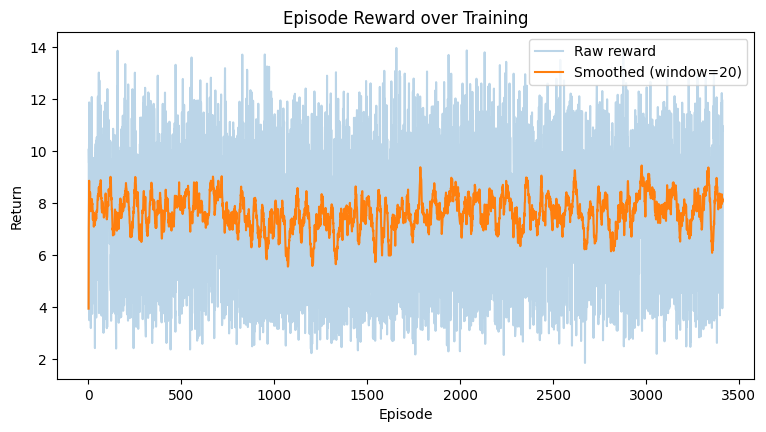

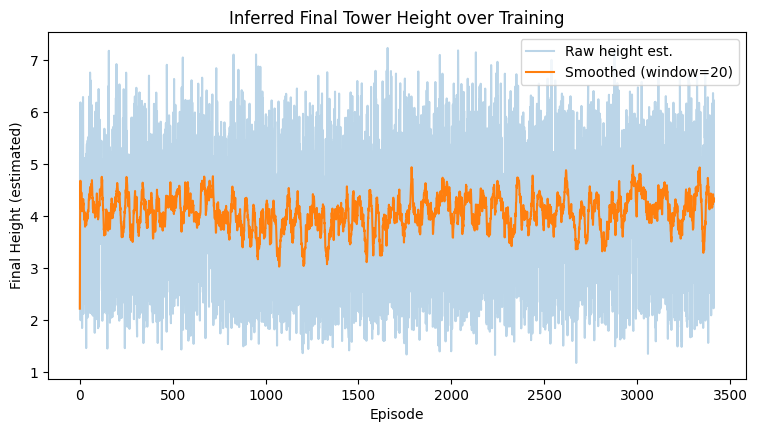

,r,l,t,episode,final_height_est,r_smooth,h_smooth
3408,4.027303,15.0,39.173854,3409,2.263651,8.194104,4.347052
3409,11.977905,15.0,39.183480,3410,6.238952,8.223810,4.361905
3410,3.966752,15.0,39.192100,3411,2.233376,8.038816,4.269408
3411,10.978686,15.0,39.202446,3412,5.739343,8.078809,4.289404
3412,10.803802,15.0,39.212922,3413,5.651901,8.144362,4.322181


In [19]:
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt

log_dir = "tower_logs"  # must match the directory used above
monitor_files = glob.glob(os.path.join(log_dir, "*.monitor.csv")) + glob.glob(os.path.join(log_dir, "monitor.csv"))

if not monitor_files:
    print("No monitor logs found.\n"
          "→ To enable logging, wrap your training env like:\n"
          "   train_env = Monitor(gym.make('TowerBuilder-v0'), filename=os.path.join('tower_logs','monitor.csv'))\n"
          "   ...then re-run a short training pass.")
else:
    # Load the first monitor file (skip the header row and '#'-prefixed metadata)
    df = pd.read_csv(
        monitor_files[0],
        skiprows=2,
        comment="#",
        names=["r", "l", "t"]  # r: episode return, l: length, t: wall time
    ).astype(float)

    df["episode"] = np.arange(1, len(df) + 1)
    ground_y = 0.5
    df["final_height_est"] = (df["r"] + ground_y) / 2.0

    # Smoothing
    window = 20
    df["r_smooth"]  = df["r"].rolling(window, min_periods=1).mean()
    df["h_smooth"]  = df["final_height_est"].rolling(window, min_periods=1).mean()

    # Plot: Episode Reward
    plt.figure(figsize=(9,4.5))
    plt.plot(df["episode"], df["r"], alpha=0.3, label="Raw reward")
    plt.plot(df["episode"], df["r_smooth"], label=f"Smoothed (window={window})")
    plt.title("Episode Reward over Training")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.legend()
    plt.show()

    # Plot: Inferred Final Height
    plt.figure(figsize=(9,4.5))
    plt.plot(df["episode"], df["final_height_est"], alpha=0.3, label="Raw height est.")
    plt.plot(df["episode"], df["h_smooth"], label=f"Smoothed (window={window})")
    plt.title("Inferred Final Tower Height over Training")
    plt.xlabel("Episode")
    plt.ylabel("Final Height (estimated)")
    plt.legend()
    plt.show()

    display(df.tail())
